# PREP

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from wildlifeml.utils.io import (
    load_csv, 
    load_json, 
    load_pickle,
)

In [3]:
REPODIR = '/home/lisa-wm/Documents/1_work/1_research/repos/wildlife-experiments'

In [4]:
CFG = load_json(os.path.join(REPODIR, 'configs/cfg.json'))
LABEL_MAP = load_json(os.path.join(REPODIR, 'data/label_map.json'))
EMPTY_CLASS = LABEL_MAP['empty']
THRESHOLDS = [0.1, 0.5, 0.9]
CONFMAT_ARGS = {
    'normalize': 'true',
    'values_format': '.2f',
    'display_labels': list(LABEL_MAP.keys()),
    'xticks_rotation': 'vertical',
    'colorbar': False,
    'cmap': 'Blues',
}

# IN-SAMPLE

In [5]:
RESULTS_INSAMPLE_EMPTY = load_pickle('results/202302071822_insample_empty.pickle')

## EMPTY DETECTION ACROSS THRESHOLDS

In [21]:
rows_empty = []
rows_multiclass = []
for t in THRESHOLDS:
    result = RESULTS_INSAMPLE_EMPTY[t]
    y_true = result['truth_imgs']
    y_pred = [np.argmax(v) for v in result['preds_imgs'].values()]
    report = classification_report(
        y_true=y_true, 
        y_pred=y_pred,
        target_names=list(LABEL_MAP.keys()),
        zero_division=0,
        output_dict=True,
    )
    rows_empty.append(
        [
            t,
            confusion_matrix(y_true, y_pred, normalize='true').diagonal()[EMPTY_CLASS],
            report['empty']['precision'],
            report['empty']['recall'],
            report['empty']['f1-score'],
        ]
    )
    rows_multiclass.append(
        [
            t,
            report['accuracy'], 
            report['macro avg']['precision'], 
            report['macro avg']['recall'], 
            report['macro avg']['f1-score']
        ]    
    )
df_ins_empty = pd.DataFrame(rows_empty, columns=['threshold', 'acc', 'prec', 'rec', 'fone'])
df_ins_multiclass = pd.DataFrame(rows_multiclass, columns=['threshold', 'acc', 'prec', 'rec', 'fone'])    

In [22]:
df_ins_empty  # Table 2

,threshold,acc,prec,rec,fone
0,0.1,0.808725,0.892593,0.808725,0.848592
1,0.5,0.875839,0.810559,0.875839,0.841935
2,0.9,0.916107,0.245946,0.916107,0.387784


In [9]:
df_ins_multiclass  # Table 3

,threshold,acc,prec,rec,fone
0,0.1,0.890544,0.840300,0.832202,0.830262
1,0.5,0.838731,0.661793,0.553113,0.591117
2,0.9,0.183938,0.103773,0.143953,0.059959


## PERFORMANCE

               precision    recall  f1-score   support

        empty       0.89      0.81      0.85       298
european_hare       0.86      0.81      0.84        63
       others       0.64      0.58      0.61       106
     red_deer       0.67      1.00      0.80         2
      red_fox       0.87      0.81      0.84       105
 red_squirrel       0.91      0.89      0.90        36
     roe_deer       0.92      0.97      0.94       905
    wild_boar       0.96      0.79      0.87        29

     accuracy                           0.89      1544
    macro avg       0.84      0.83      0.83      1544
 weighted avg       0.89      0.89      0.89      1544



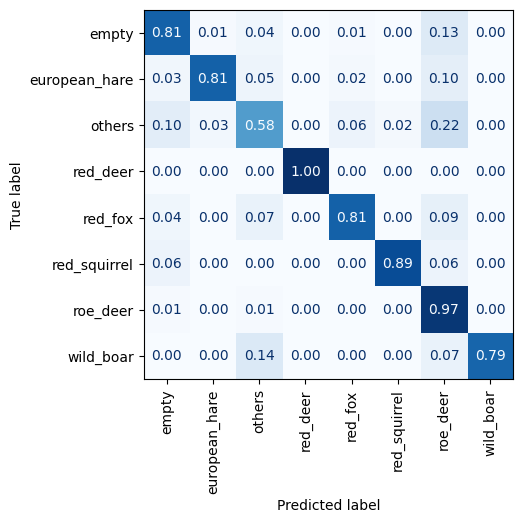

In [10]:
result_ours = RESULTS_INSAMPLE_EMPTY[THRESHOLDS[0]]
y_true = result_ours['truth_imgs']
y_pred = [np.argmax(v) for v in result_ours['preds_imgs'].values()]
report = classification_report(
    y_true=y_true, 
    y_pred=y_pred,
    target_names=list(LABEL_MAP.keys())
)
print(report)  # Figure 3
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, **CONFMAT_ARGS)

# OUT-OF-SAMPLE

## PERFORMANCE

In [11]:
RESULTS_OOSAMPLE_PERF = load_pickle('results/202302072154_oosample_perf.pickle')

In [12]:
y_true = RESULTS_OOSAMPLE_PERF['truth_imgs']
y_pred = [np.argmax(v) for v in RESULTS_OOSAMPLE_PERF['preds_imgs'].values()]
report_dict = classification_report(
    y_true=y_true, 
    y_pred=y_pred,
    target_names=list(LABEL_MAP.keys()),
    output_dict=True,
)
rows_oos_multiclass = []
rows_oos_multiclass.append(
    [
        report_dict['accuracy'], 
        report_dict['macro avg']['precision'], 
        report_dict['macro avg']['recall'], 
        report_dict['macro avg']['f1-score']
    ]
)
df_oos_multiclass = pd.DataFrame(
    rows_oos_multiclass,
    columns=['acc', 'prec', 'rec', 'fone']
)
df_multiclass = pd.concat([df_ins_multiclass.loc[df_ins_multiclass['threshold'] == 0.1], df_oos_multiclass])
df_multiclass.index = ['ins', 'oos']

In [13]:
df_multiclass.drop(['threshold'], axis=1)  # Table 5

,acc,prec,rec,fone
ins,0.890544,0.840300,0.832202,0.830262
oos,0.748503,0.478476,0.536268,0.440601


               precision    recall  f1-score   support

        empty       0.86      0.46      0.60       334
european_hare       0.64      0.54      0.58        39
       others       0.36      0.34      0.35       110
     red_deer       0.00      0.00      0.00        22
      red_fox       0.26      0.42      0.32        19
 red_squirrel       0.06      1.00      0.11         1
     roe_deer       0.78      0.93      0.85      1028
    wild_boar       0.88      0.60      0.71       117

     accuracy                           0.75      1670
    macro avg       0.48      0.54      0.44      1670
 weighted avg       0.76      0.75      0.73      1670



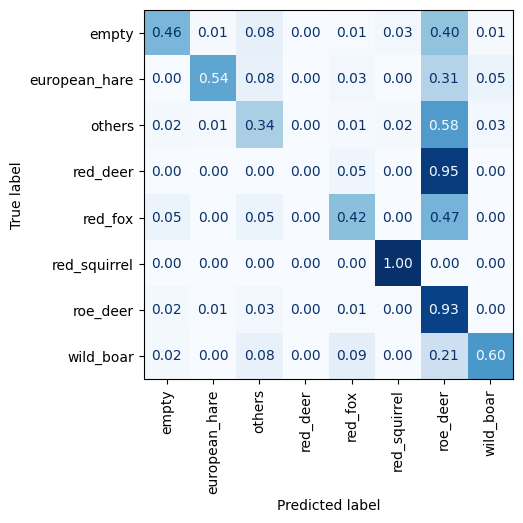

In [14]:
print(  # Figure 5
    classification_report(
        y_true=y_true, 
        y_pred=y_pred,
        target_names=list(LABEL_MAP.keys())
    )

) 
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, **CONFMAT_ARGS)

## ACTIVE LEARNING

In [ ]:
# eval_upper_perf_limit = load_pickle(
#     'results/202212011038_results_oosample_active_optimal.json'
# )
# eval_al_coldstart = load_pickle('results/202212041731_eval_logfile_coldstart.json')
# eval_al_warmstart = load_pickle('results/202212080940_eval_logfile_warmstart.json')
# # compute relative sample size per iteration
# # (sizes hard-coded for training)
# n_samples_total = len(load_pickle('data/dataset_oos_trainval.pkl').keys)
# num_max_batches = (
#     (n_samples_total - (5 * 128 + 5 * 256 + 5 * 512)) // 1024
# )
# size_last_batch = (
#     n_samples_total - (5 * 128 + 5 * 256 + 5 * 512 + num_max_batches * 1024)
# )
# batch_sizes = (
#     5 * [128] + 5 * [256] + 5 * [512] + num_max_batches * [1024]
# )
# if size_last_batch > 0:
#     batch_sizes.append(size_last_batch)
# batch_sizes_cs = np.cumsum([x / n_samples_total for x in batch_sizes])
# # inspect upper performance limit
# df_pred_upper_perf_limit = rf.build_df_pred(eval_upper_perf_limit, label_dict, detector_dict, image_data_dir)
# df_pred_upper_perf_limit = rf.labelize_df_pred(df_pred_upper_perf_limit, label_map)
# df_pred_upper_perf_limit = pd.merge(df_pred_upper_perf_limit, df_meta, on=['img_name', 'true_class'], how='inner')
# report_upper_perf_limit = classification_report(
#     y_true=df_pred_upper_perf_limit['true_class'],
#     y_pred=df_pred_upper_perf_limit['pred_class'],
#     labels=labels,
#     zero_division=0,
#     output_dict=False,
# )
# print(report_upper_perf_limit)

# rf.inspect_confusion(
#     df_pred=df_pred_upper_perf_limit,
#     normalize=True,
#     labels=labels,
#     ax=None,
# )
# report_upper_perf_limit_dict = classification_report(
#     y_true=df_pred_upper_perf_limit['true_class'],
#     y_pred=df_pred_upper_perf_limit['pred_class'],
#     labels=labels,
#     zero_division=0,
#     output_dict=True,
# )
# print(report_upper_perf_limit_dict)
# # compute metrics per iteration

# acc_coldstart = []
# rec_coldstart = []
# acc_warmstart = []
# rec_warmstart = []

# for iteration in eval_al_coldstart.keys():
#     df_cs = rf.build_df_pred(eval_al_coldstart[iteration], label_dict, detector_dict, image_data_dir)
#     df_cs = rf.labelize_df_pred(df_cs, label_map)
#     df_cs = pd.merge(df_cs, df_meta, on=['img_name', 'true_class'], how='inner')
#     report_cs = classification_report(
#         y_true=df_cs['true_class'],
#         y_pred=df_cs['pred_class'],
#         labels=labels,
#         zero_division=0,
#         output_dict=True,
#     )
#     df_ws = rf.build_df_pred(eval_al_warmstart[iteration], label_dict, detector_dict, image_data_dir)
#     df_ws = rf.labelize_df_pred(df_ws, label_map)
#     df_ws = pd.merge(df_ws, df_meta, on=['img_name', 'true_class'], how='inner')
#     report_ws = classification_report(
#         y_true=df_ws['true_class'],
#         y_pred=df_ws['pred_class'],
#         labels=labels,
#         zero_division=0,
#         output_dict=True,
#     )
#     acc_coldstart.append(report_cs['accuracy'])
#     rec_coldstart.append(report_cs['weighted avg']['recall'])
#     acc_warmstart.append(report_ws['accuracy'])
#     rec_warmstart.append(report_ws['weighted avg']['recall'])

# # create data for plot
# al_perf_acc = {
#     'relative_size': batch_sizes_cs[1:],
#     'acc_lower_limit': [report_lower_perf_limit_dict['accuracy'] for _ in range(len(acc_coldstart))],
#     'acc_upper_limit': [report_upper_perf_limit_dict['accuracy'] for _ in range(len(acc_coldstart))],
#     'acc_coldstart': acc_coldstart,
#     'acc_warmstart': acc_warmstart
# }
# al_perf_acc_pd = pd.DataFrame(al_perf_acc)
# al_perf_rec = {
#     'relative_size': batch_sizes_cs[1:],
#     'rec_lower_limit': [report_lower_perf_limit_dict['weighted avg']['recall'] for _ in range(len(acc_coldstart))],
#     'rec_upper_limit': [report_upper_perf_limit_dict['weighted avg']['recall'] for _ in range(len(acc_coldstart))],
#     'rec_coldstart': rec_coldstart,
#     'rec_warmstart': rec_warmstart
# }
# al_perf_acc_pd = pd.DataFrame(al_perf_acc)
# al_perf_rec_pd = pd.DataFrame(al_perf_rec)
# plt = sns.lineplot(
#     data=pd.melt(al_perf_acc_pd, id_vars='relative_size'),
#     x='relative_size',
#     y='value',
#     hue='variable',
#     style='variable'
# )
# plt.set(xlabel='relative sample size', ylabel='accuracy')
# plt.legend(
#     title='training mode', 
#     loc='lower right', 
#     labels=['lower baseline', 'upper baseline', 'cold start', 'warm start']
# )
# plt.figure.savefig('oos_active.eps')